In [1]:
# Ensure notebook is being run from base repository directory
import os, sys
try:
    os.chdir(os.environ["COVID_HOME"])
except Exception as err:
    print(f"Warning: unable to change directory; {repr(err)}")
from src.utils.notebook_util import isnotebook
if isnotebook():
    # Autoreload packages that are modified
    %load_ext autoreload
    %autoreload 2
else:
    from argparse import ArgumentParser
    
# Computational libraries 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
from collections import deque

# os libraries 
import shutil
from datetime import datetime, timedelta
from functools import partial
import copy
import pdb
import os

from utils import *
from file_util import *
from attributes import *

from zoo_of_experts import *
from zoo_of_hinters import *
from zoo_of_losses import *

import matplotlib.pyplot as plt

In [3]:
#
# Specify model parameters
#
model_name = "online_expert" 

if not isnotebook():
    # If notebook run as a script, parse command-line arguments
    parser = ArgumentParser()
    parser.add_argument("pos_vars",nargs="*")  # gt_id and horizon 
    parser.add_argument('--target_dates', '-t', default="std_future")
    args, opt = parser.parse_known_args()
    
    # Assign variables                                                                                                                                     
    gt_id = get_id_name(args.pos_vars[0]) # "contest_precip" or "contest_tmp2m"                                                                            
    horizon = get_th_name(args.pos_vars[1]) # "34w" or "56w"    
    target_date_str = args.target_dates # target date object
else:
    # Otherwise, specify arguments interactively
    gt_id = "cumm_death" #"contest_precip", "contest_tmp2m"    
    target_date_str = "std_weekly" #"contest_precip", "contest_tmp2m"
    location = 'US'
    quantile = 0.5
    horizon = "1w"

In [7]:
"""
Read in ground truth and model predictions for task
"""
# Get location FIPS codes
fips_codes = get_fips_codes() 

# Read ground truth 
printf(f'Loading {gt_id} ground truth')
df_gt = get_ground_truth(gt_id, location, load_df=True)

# Get target dates
first_date, last_date = get_data_range(gt_id, location=location)
printf(f"Getting target dates from {first_date} to {last_date}.")
target_dates = get_target_dates(target_date_str, first_date, last_date)
target_date_objs = pd.Series(target_dates)

# Store delta between target date and forecast issuance date
start_delta = timedelta(days=get_start_delta(horizon, gt_id))

# Get model predicitons for the task
printf(f'Loading model predictions for {gt_id}, {horizon}, {location}, q{quantile}')
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)

# Get model list
persistant_models, all_models = get_persistant_models(model_pred_df)
expert_models = list(all_models)
expert_models.sort()
model_string = (',').join(expert_models)
printf(f"Predictions for models loaded:\n {expert_models}")

Loading cumm_death ground truth
Getting target dates from 2020-01-22 00:00:00 to 2020-10-24 00:00:00.
Loading model predictions for cumm_death, 1w, US, q0.5
Predictions for models loaded:
 ['Auquan-SEIR', 'BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator', 'CovidActNow-SEIR_CAN', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'GT-DeepCOVID', 'IHME-CurveFit', 'Imperial-ensemble1', 'Imperial-ensemble2', 'IowaStateLW-STEM', 'JHUAPL-Bucky', 'JHU_IDD-CovidSP', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'MITCovAlliance-SIR', 'MOBS-GLEAM_COVID', 'MSRA-DeepST', 'NotreDame-mobility', 'OliverWyman-Navigator', 'PSI-DRAFT', 'RPI_UW-Mob_Collision', 'RobertWalraven-ESG', 'SWC-TerminusCM', 'SteveMcConnell-CovidComplete', 'UA-EpiCovDA', 'UCLA-SuEIR', 'UCM_MESALab-FoGSEIR', 'UCSD_NEU-DeepGLEAM', 'UMass-MechBayes', 'UMich-RidgeTfReg', 'USACE-ERDC_SEIR', 'U

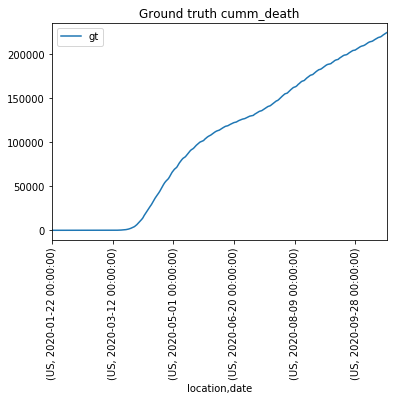

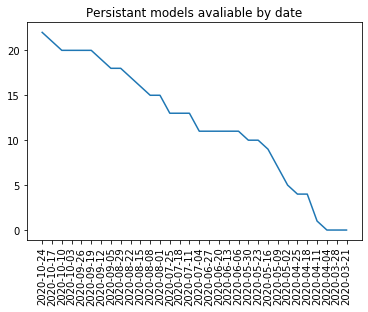

In [8]:
"""
Visualize ground truth 
"""
df_gt.plot()
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()

"""
Visualize avalible models
"""
plt.plot(list(persistant_models.keys()), [len(x) for x in persistant_models.values()])
plt.xticks(rotation=90)
plt.title('Persistant models avaliable by date')
plt.show()